# **Starter**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

PATH = '/content/drive/MyDrive/Voice Spoof/ASVspoof2021_LA_eval/flac'
df = pd.read_csv('/content/drive/MyDrive/Voice Spoof/keys/LA/CM/trial_metadata.txt', delimiter=' ', header = None)
df = df.rename(columns={1: 'file_name'})
df = df.rename(columns={5: 'labels'})

In [ ]:
df.head()


,0,file_name,2,3,4,labels,6,7
0,LA_0009,LA_E_9332881,alaw,ita_tx,A07,spoof,notrim,eval
1,LA_0009,LA_E_6866159,alaw,ita_tx,A07,spoof,notrim,eval
2,LA_0009,LA_E_5464494,alaw,sin_tx,A07,spoof,notrim,eval
3,LA_0009,LA_E_4759417,alaw,sin_tx,A07,spoof,notrim,eval
4,LA_0009,LA_E_2667748,alaw,loc_tx,A07,spoof,notrim,eval


In [ ]:
# import os

# folder_path = '/content/drive/MyDrive/Voice Spoof/ASVspoof2021_LA_eval/flac'

# # Ensure the folder path is correct and exists
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     # List all files in the folder
#     files = os.listdir(folder_path)

#     # Filter out only files (not directories)
#     files = [file for file in files if os.path.isfile(os.path.join(folder_path, file))]

#     # Print the number of files
#     print(f"Number of files in '{folder_path}': {len(files)}")
# else:
#     print(f"The folder '{folder_path}' does not exist.")


Number of files in '/content/drive/MyDrive/Voice Spoof/ASVspoof2021_LA_eval/flac': 56251


In [ ]:
# # Create a new DataFrame from the new data
# df_files = pd.DataFrame({'file_name': files})
# df['file_name'] = df['file_name'] + '.flac'

merged_df = pd.read_csv("/content/drive/MyDrive/Voice Spoof/merged_data.csv")
merged_df["labels"] = merged_df["labels"].replace({'spoof': 0, 'bonafide': 1}) # 0 ปลอม, 1 จริง

In [ ]:
merged_df["7"].value_counts()

eval        45952
hidden       5244
progress     5055
Name: 7, dtype: int64

In [ ]:
# # Save the merged DataFrame to a CSV file
# merged_df.to_csv('/content/drive/MyDrive/Voice Spoof/merged_data.csv', index=False)

In [ ]:
eval = merged_df[merged_df["7"] == 'eval'] # test
hidden = merged_df[merged_df["7"] == 'hidden'] # eval
progress = merged_df[merged_df["7"] == 'progress'] # train

In [ ]:
progress["labels"].value_counts()

0    4539
1     516
Name: labels, dtype: int64

In [ ]:
hidden["labels"].value_counts()

0    4647
1     597
Name: labels, dtype: int64

In [ ]:
eval["labels"].value_counts()

0    41399
1     4553
Name: labels, dtype: int64

# **MQCC**

In [ ]:
import numpy as np
from scipy.io import wavfile
import librosa
import soundfile as sf

count = 0

def extract_mfcc_features(file_path, sr_limit=80000, n_mfcc=13, max_length=157):
    global count
    try:
        data, sr = sf.read(file_path)

        if sr > sr_limit:
            # Resample the audio if the sampling rate is higher than the limit
            data = librosa.resample(data, sr, sr_limit)
            sr = sr_limit

        mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)

        # Pad or truncate the features to the fixed length
        if mfccs.shape[1] < max_length:
            # Pad if the features are shorter than the desired length
            mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant', constant_values=0)
        elif mfccs.shape[1] > max_length:
            # Truncate if the features are longer than the desired length
            mfccs = mfccs[:, :max_length]

        count += 1
        print(count)
        return mfccs
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

import concurrent.futures
from sklearn.model_selection import train_test_split

# Your existing functions

def process_file(path, max_length=157):
    return extract_mfcc_features(path, max_length=max_length)

def create_mfcc_features_parallel(data_paths, max_length=157):
    mfcc_features = []

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(executor.map(process_file, data_paths, [max_length]*len(data_paths)))

    for result in results:
        if result is not None:
            mfcc_features.append(result)

    return np.array(mfcc_features)



In [ ]:
# Assuming 'x_train' and 'x_test' are lists of audio file paths for training and testing data respectively
# X_train = create_mfcc_features_parallel(progress["file_path"])
# X_test = create_mfcc_features_parallel(eval["file_path"])
# X_val = create_mfcc_features_parallel(hidden["file_path"])

In [ ]:
# np.save("/content/drive/MyDrive/Voice Spoof/mqcc_features_progress.npy", X_train)
# np.save("/content/drive/MyDrive/Voice Spoof/mqcc_features_eval.npy", X_test)
# np.save("/content/drive/MyDrive/Voice Spoof/mqcc_features_hidden.npy", X_val)

In [ ]:
X_train = np.load("/content/drive/MyDrive/Voice Spoof/mqcc_features_progress.npy")
X_test = np.load("/content/drive/MyDrive/Voice Spoof/mqcc_features_eval.npy")
X_val = np.load("/content/drive/MyDrive/Voice Spoof/mqcc_features_hidden.npy")

In [ ]:
X_train

In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))

y_train = progress["labels"]
y_test = eval["labels"]
y_val = hidden["labels"]

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_reshaped, y_train)


In [ ]:
X_train_resampled.shape

(9078, 2041)

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib.pyplot as plt
# from sklearn.svm import SVC

# # Create and train a Logistic Regression model
# class_weight = {1: 4.898255813953488, 0: 0.5568407138136153}

# logistic_model = LogisticRegression(random_state=42, class_weight= class_weight)
# svc_model = SVC(class_weight='balanced', probability=True)
# random_forest_model = RandomForestClassifier(random_state=42)
# # logistic_model.fit(X_train, y_train)
# random_forest_model.fit(X_train_resampled, y_train_resampled)

# # Predict on the test set
# y_pred = random_forest_model.predict(X_test_reshaped)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Print classification report
# print("Classification Report:")
# print(classification_report(y_test, y_pred))


Accuracy: 92.71%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     41399
           1       0.69      0.48      0.57      4553

    accuracy                           0.93     45952
   macro avg       0.82      0.73      0.76     45952
weighted avg       0.92      0.93      0.92     45952



In [ ]:
# from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
# fpr, tpr, thresholds = roc_curve(y_test, random_forest_model.predict_proba(X_test_reshaped)[:, 1])

# # Calculate AUC (Area Under the Curve)
# roc_auc = auc(fpr, tpr)
# print(f"AUC: {roc_auc * 100:.2f}%")
# # Calculate EER
# cm = confusion_matrix(y_test, y_pred)
# eer = (cm[0, 1] / (cm[0, 1] + cm[1, 0] + 1e-10) + cm[1, 0] / (cm[1, 0] + cm[1, 1] + 1e-10)) / 2
# print(f"EER: {eer * 100:.2f}%")

AUC: 95.47%
EER: 40.65%


In [ ]:
len(y_pred)

45952

In [ ]:
from tensorflow.keras import layers, models, callbacks

# Assuming your input shape is (13, 157, 1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

model = models.Sequential()

# Block 1
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

# Block 2
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Block 3
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 13, 157, 64)       640       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 78, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 78, 128)        73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 39, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 39, 256)        295168    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 1, 19, 256)       

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGGish
from tensorflow.keras.optimizers import Adam

# Assuming your input shape is (num_samples, num_frames, num_mfcc_features)
input_shape = (X_train.shape[1], X_train.shape[2])

# Load pre-trained VGGish model
vggish_model = VGGish(include_top=False, input_shape=input_shape)

# Freeze the layers in the VGGish model
for layer in vggish_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained VGGish model
model = Sequential([
    vggish_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


In [ ]:
# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)

history = model.fit(X_train, y_train, epochs=20, callbacks=[early_stopping, tensorboard], validation_data=(X_val, y_val))

Epoch 1/20
158/158 [==============================] - 52s 289ms/step - loss: 0.2083 - accuracy: 0.9132 - val_loss: 2.1901 - val_accuracy: 0.8862
Epoch 2/20
158/158 [==============================] - 43s 272ms/step - loss: 0.1818 - accuracy: 0.9100 - val_loss: 0.9725 - val_accuracy: 0.8848
Epoch 3/20
158/158 [==============================] - 44s 280ms/step - loss: 0.1158 - accuracy: 0.9517 - val_loss: 0.9465 - val_accuracy: 0.8862
Epoch 4/20
158/158 [==============================] - 43s 270ms/step - loss: 0.1071 - accuracy: 0.9517 - val_loss: 0.8608 - val_accuracy: 0.8860
Epoch 5/20
158/158 [==============================] - 42s 268ms/step - loss: 0.0952 - accuracy: 0.9575 - val_loss: 1.0061 - val_accuracy: 0.8850
Epoch 6/20
158/158 [==============================] - 42s 264ms/step - loss: 0.0930 - accuracy: 0.9557 - val_loss: 0.7716 - val_accuracy: 0.8862
Epoch 7/20
158/158 [==============================] - 41s 260ms/step - loss: 0.0923 - accuracy: 0.9573 - val_loss: 0.8353 - val_ac

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


1436/1436 [==============================] - 165s 115ms/step - loss: 0.2338 - accuracy: 0.9462
Test Accuracy: 0.9462047219276428


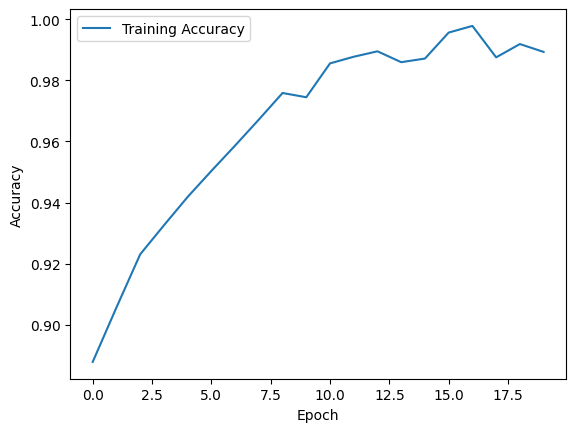

1436/1436 [==============================] - 162s 113ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     41399
           1       0.74      0.69      0.72      4553

    accuracy                           0.95     45952
   macro avg       0.86      0.83      0.84     45952
weighted avg       0.94      0.95      0.95     45952



In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate predictions on the test set
y_pred = model.predict(X_test)
# Assuming y_pred is your array of predicted probabilities
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
y_pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate Equal Error Rate (EER)
eer_threshold = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer = 1. - interp1d(fpr, tpr)(eer_threshold)
print(f'Equal Error Rate (EER): {eer:.4f} ')

Equal Error Rate (EER): 0.2792


In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Calculate Equal Error Rate (EER)
eer_threshold = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer = 1. - interp1d(fpr, tpr)(eer_threshold)
print(f'Equal Error Rate (EER): {eer:.4f} ')

Equal Error Rate (EER): 0.2385 


# **Spec**

In [ ]:
import pandas as pd
import librosa
import numpy as np
from concurrent.futures import ThreadPoolExecutor

count = 0  # Initialize count variable

def extract_spectrogram(audio_path, target_length=5.0):
    global count
    try:
        # Load audio file
        y, sr = librosa.load(audio_path)

        # Ensure the audio has the target duration
        target_samples = int(target_length * sr)
        if len(y) < target_samples:
            y = np.pad(y, (0, target_samples - len(y)), 'constant')
        elif len(y) > target_samples:
            y = y[:target_samples]

        # Compute the spectrogram
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

        count += 1
        print(count)

        # Convert to decibels (log scale)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        return spectrogram_db
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return None

def extract_spectrogram_parallel(row):
    return extract_spectrogram(row.file_path)

In [ ]:
with ThreadPoolExecutor() as executor:
    # Apply extract_spectrogram_parallel to each row in the DataFrame
    results = list(executor.map(extract_spectrogram_parallel, progress.itertuples(index=False)))

# Filter out any None results (error cases)
spectrograms = [result for result in results if result is not None]

X_train = np.array(spectrograms)

In [ ]:
X_train.shape

(5055, 128, 216)

In [ ]:
with ThreadPoolExecutor() as executor:
    # Apply extract_spectrogram_parallel to each row in the DataFrame
    results = list(executor.map(extract_spectrogram_parallel, hidden.itertuples(index=False)))

# Filter out any None results (error cases)
spectrograms = [result for result in results if result is not None]

X_val = np.array(spectrograms)

In [ ]:
del results

In [ ]:
with ThreadPoolExecutor() as executor:
    # Apply extract_spectrogram_parallel to each row in the DataFrame
    results = list(executor.map(extract_spectrogram_parallel, eval.itertuples(index=False)))

# Filter out any None results (error cases)
spectrograms = [result for result in results if result is not None]

X_test = np.array(spectrograms)

In [ ]:
# np.save("/content/drive/MyDrive/Voice Spoof/Spec/spectrogram_features_progressl.npy", X_train)
# np.save("/content/drive/MyDrive/Voice Spoof/Spec/spectrogram_features_eval.npy", X_test)
# np.save("/content/drive/MyDrive/Voice Spoof/Spec/spectrogram_features_hidden.npy", X_val)

In [ ]:
X_train = np.load("/content/drive/MyDrive/Voice Spoof/Spec/spectrogram_features_progressl.npy")
X_test = np.load("/content/drive/MyDrive/Voice Spoof/Spec/spectrogram_features_eval.npy")
X_val = np.load("/content/drive/MyDrive/Voice Spoof/Spec/spectrogram_features_hidden.npy")

In [ ]:
y_train = progress["labels"]
y_test = eval["labels"]
y_val = hidden["labels"]

In [ ]:
from tensorflow.keras import layers, models, callbacks

# Assuming your input shape is (13, 157, 1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

model = models.Sequential()

# Block 1
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

# Block 2
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Block 3
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


# **Load**

In [ ]:
import numpy as np

# Load the NumPy array
features_array_progress = np.load('/content/drive/MyDrive/Voice Spoof/lfcc_features_progress.npy', allow_pickle=True)
features_array_eval = np.load('/content/drive/MyDrive/Voice Spoof/lfcc_features1_eval.npy', allow_pickle=True)

X_train_array = np.array(features_array_progress.tolist())
X_test_array = np.array(features_array_eval.tolist())

X_train = np.concatenate([arr.flatten().reshape(1, -1) for arr in X_train_array])
X_test = np.concatenate([arr.flatten().reshape(1, -1) for arr in X_test_array])

y_train = progress.labels
y_test = eval['labels'][:6000]



In [ ]:
X_train_array.shape

(5055, 13, 1249)

In [ ]:
X_train.shape

(5055, 16237)

In [ ]:
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.model_selection import train_test_split

# # Apply RandomOverSampler to balance the training set
# oversampler = RandomOverSampler(random_state=42)
# X_train_resample, y_train_resample = oversampler.fit_resample(X_train, y_train)

In [ ]:
# X_train_resample

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Create and train a Logistic Regression model
class_weight = {1: 4.898255813953488, 0: 0.5568407138136153}

logistic_model = LogisticRegression(random_state=42, class_weight= class_weight)
svc_model = SVC(class_weight='balanced', probability=True)
random_forest_model = RandomForestClassifier(random_state=42, class_weight=class_weight)
# logistic_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 91.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5417
           1       0.64      0.30      0.41       583

    accuracy                           0.92      6000
   macro avg       0.79      0.64      0.68      6000
weighted avg       0.90      0.92      0.90      6000



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
fpr, tpr, thresholds = roc_curve(y_test, random_forest_model.predict_proba(X_test)[:, 1])

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc * 100:.2f}%")
# Calculate EER
cm = confusion_matrix(y_test, y_pred)
eer = (cm[0, 1] / (cm[0, 1] + cm[1, 0] + 1e-10) + cm[1, 0] / (cm[1, 0] + cm[1, 1] + 1e-10)) / 2
print(f"EER: {eer * 100:.2f}%")

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Define the imbalance ratio (number of negative samples / number of positive samples)
imbalance_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

# Create and train an XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 91.12%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5417
           1       0.55      0.44      0.49       583

    accuracy                           0.91      6000
   macro avg       0.75      0.70      0.72      6000
weighted avg       0.90      0.91      0.91      6000



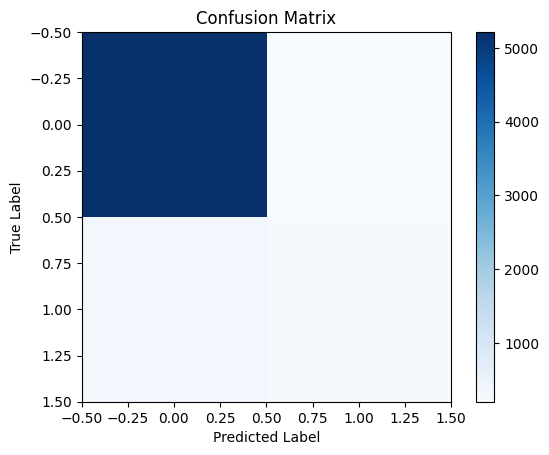

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Create and train a Linear SVM model
linear_svm = LinearSVC(class_weight='balanced', random_state=42)
linear_svm.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
X_train

array([[-506.96725464, -323.92282104, -304.43579102, ...,    0.        ,
           0.        ,    0.        ],
       [-547.13000488, -544.06365967, -546.26849365, ...,    0.        ,
           0.        ,    0.        ],
       [-487.18756104, -486.42007446, -485.81799316, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [-544.1138916 , -537.80664062, -546.23852539, ...,    0.        ,
           0.        ,    0.        ],
       [-526.33007812, -522.53833008, -475.1708374 , ...,    0.        ,
           0.        ,    0.        ],
       [-503.01815796, -475.58798218, -461.5864563 , ...,    0.        ,
           0.        ,    0.        ]])

In [ ]:
X_test

array([[-514.14343262, -515.20629883, -466.6473999 , ...,    0.        ,
           0.        ,    0.        ],
       [-451.56542969, -505.31506348, -502.76333618, ...,    0.        ,
           0.        ,    0.        ],
       [-509.18884277, -508.07476807, -497.55334473, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [-511.65530396, -507.24224854, -463.36804199, ...,    0.        ,
           0.        ,    0.        ],
       [-430.50921631, -483.89242554, -468.26620483, ...,    0.        ,
           0.        ,    0.        ],
       [-367.38967896, -360.62094116, -379.18954468, ...,    0.        ,
           0.        ,    0.        ]])

# **LCNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def lcnn_model(input_shape):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))

    # Output layer with sigmoid activation for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Assuming your input data has shape (num_samples, height, width, channels)
input_shape = X_train_array.shape

# Create LCNN model
model = lcnn_model(reshaped_data)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


TypeError: ignored

In [ ]:
import numpy as np

# Assuming your original data has shape (5055, 13, 1249)
original_data = np.random.rand(5055, 13, 1249)  # Replace this with your actual data

# Reshape the data for a CNN or LCNN model
height, width, channels = 13, 1249, 1  # You may need to adjust these values based on your data
reshaped_data = X_train_array.reshape(-1, height, width, channels)

# Now reshaped_data has shape (5055, 13, 1249, 1)


In [ ]:
reshaped_data

array([[[[0.44929454],
         [0.41854522],
         [0.31365755],
         ...,
         [0.27297814],
         [0.42674628],
         [0.30397893]],

        [[0.04783142],
         [0.07583302],
         [0.76177904],
         ...,
         [0.7344715 ],
         [0.12566478],
         [0.6387242 ]],

        [[0.68253939],
         [0.4602444 ],
         [0.04166553],
         ...,
         [0.48015784],
         [0.28960269],
         [0.03533654]],

        ...,

        [[0.80489627],
         [0.55042368],
         [0.402834  ],
         ...,
         [0.63260845],
         [0.56133691],
         [0.38251065]],

        [[0.92407071],
         [0.27663498],
         [0.27554839],
         ...,
         [0.76460443],
         [0.95227367],
         [0.31257656]],

        [[0.63776071],
         [0.25750375],
         [0.38349153],
         ...,
         [0.67809482],
         [0.27242333],
         [0.76507219]]],


       [[[0.68601437],
         [0.1807316 ],
         [0.71